# 1. Normal (unknown variance)

We want to estimate the variance from the following problem:
$$
\sigma \sim \mathcal U(0, A)
$$
As our prior, and then our likelihood function is:
$$
x \mid \sigma \sim \mathcal N(0, \sigma^2)
$$

This means that our likeihood is:
$$
p(x \mid \sigma) = \prod_{i=1}^{n} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{x_i^2}{2 \sigma^2}\right)
$$
And our uniform prior $p(\sigma) = \frac{1}{A}\cdot \mathbb{1}_{0 < \sigma < A}$.

Therefore, the posterior is given by Bayes' theorem:
$$
\begin{aligned}
p(\sigma \mid x) & \propto p(x \mid \sigma) p(\sigma) \\
&\,\,\, =\frac{1}{A}\cdot \mathbb{1}_{0 < \sigma < A} \cdot \prod_{i=1}^{n} \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{x_i^2}{2 \sigma^2}\right) \\
&\,\,\, =\frac{1}{A}\cdot \mathbb{1}_{0 < \sigma < A} \cdot \sigma^{-n} \exp\left(-\frac{S}{2 \sigma^2} \right)

\end{aligned}
$$

Where we can write our *summary statistic* as $S:=\sum_{i=1}^{n} x_i^2$.

Note that the posterior has no simple closed-form mean - hence we will use MCMC to sample from it.

## Data generation

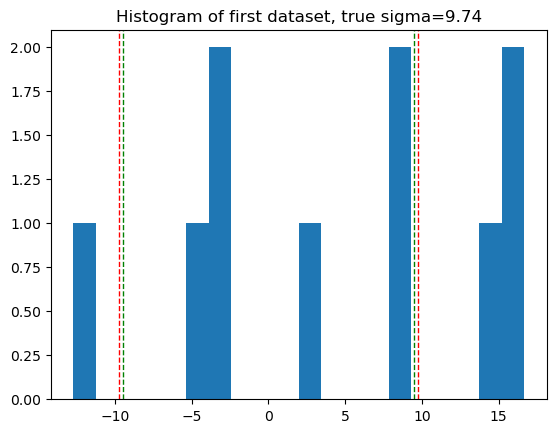

Text(0, 0.5, 'Sample std dev')

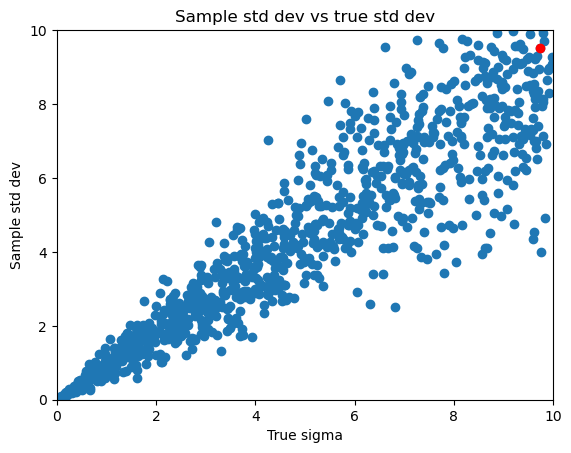

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

A = 10
k = 1000 # number of datasets
n = 10 # samples per dataset

np.random.seed(0)

sigmas = np.random.uniform(0, A, size=k)
X = np.random.normal(0, sigmas[:, None], size=(k, n))

index_to_plot = 420

# plot first sigma vs its x's
plt.figure()
plt.hist(X[index_to_plot], bins=20)
plt.axvline(sigmas[index_to_plot], color='r', linestyle='dashed', linewidth=1)
plt.axvline(-sigmas[index_to_plot], color='r', linestyle='dashed', linewidth=1)
plt.axvline(np.std(X[index_to_plot]), color='g', linestyle='dashed', linewidth=1)
plt.axvline(-np.std(X[index_to_plot]), color='g', linestyle='dashed', linewidth=1)
plt.title(f"Histogram of first dataset, true sigma={sigmas[index_to_plot]:.2f}")
plt.show()


# plot sigma vs x's sigma on x-axis
plt.scatter(sigmas, np.std(X, axis=1))
plt.xlim(0, A)
plt.ylim(0, A)
plt.title("Sample std dev vs true std dev")
plt.scatter(sigmas[index_to_plot], np.std(X[index_to_plot]), color='r')
plt.xlabel("True sigma")
plt.ylabel("Sample std dev")

## Metropolis-Hastings (MH)

Metropolis-Hastings should work here given this is a 1D problem. The algorithm is as follows:
1. Initialize $\sigma_0$ (e.g., randomly from the prior).
2. For each iteration $i = 1, 2, \ldots, N$
    a. Propose a new value $\sigma^*$ from a proposal distribution $q(\sigma^* \mid \sigma_i)$.
    b. Calculate the acceptance ratio:
    $$
    \alpha = \min\left(1, \frac{p(\sigma^* \mid x) q(\sigma_i \mid \sigma^*)}{p(\sigma_i \mid x) q(\sigma^* \mid \sigma_i)}\right)
    $$
    c. Generate a uniform random number $u \sim \mathcal U(0, 1)$.
    d. If $u < \alpha$, accept the proposal and set $\sigma_{i+1} = \sigma^*$; otherwise, reject it and set $\sigma_{i+1} = \sigma_i$.



In our case we will use the following proposal distribution:
$$
q(\sigma^* \mid \sigma_i) = \mathcal N(\sigma_i, \tau^2)
$$
where $\tau$ is a tuning parameter that controls the step size of the proposals.

We will ignore the 

Acceptance rate: 0.77


C:\Users\kaima\AppData\Local\Temp\ipykernel_7736\2674783141.py:23: RuntimeWarning: invalid value encountered in scalar divide
  acceptance_ratio = p_proposal / p_current
C:\Users\kaima\AppData\Local\Temp\ipykernel_7736\2674783141.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  acceptance_ratio = p_proposal / p_current


Text(0.5, 1.0, 'Time series of sigma samples (naive MH)')

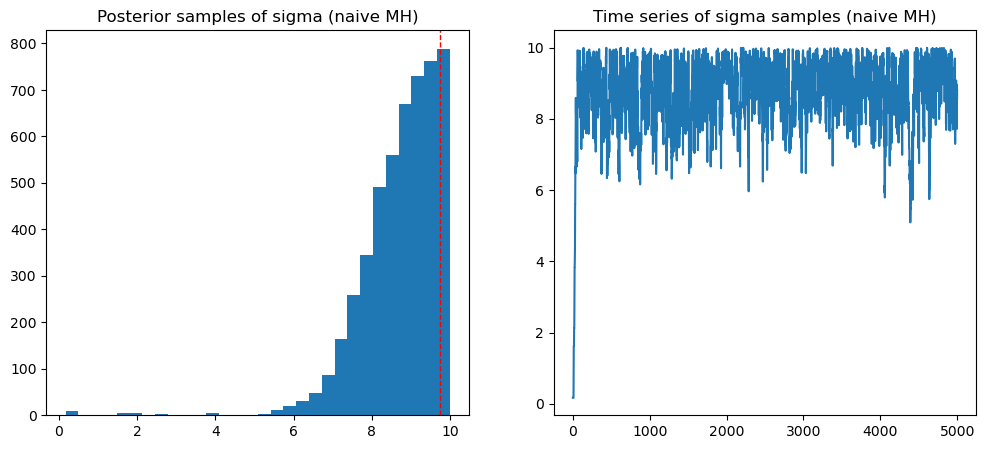

In [130]:
# first we implement the naive implementation (without log probabilities - needed for better numerical stability)
def posterior_sigma(sigma, S, n, A):
    if sigma <= 0 or sigma >= A:
        return 0.0
    return sigma**(-n) * np.exp(-S / (2 * sigma**2))

def metropolis_hastings_naive(S, n, A, n_samples=5000, tau=0.5, burn_in=1000):
    samples = np.zeros(n_samples)
    
    sigma = np.random.uniform(0, A)
    samples[0] = sigma
    acceptance_count = 0

    for i in range(1, n_samples):
        sigma_proposal = sigma + np.random.normal(0, tau)

        p_current = posterior_sigma(sigma, S, n, A)
        p_proposal = posterior_sigma(sigma_proposal, S, n, A)

        # q_current = np.random.normal(sigma_current, tau)
        # q_proposal = np.random.normal(sigma_proposal, tau)  # Symmetric -> cancels out

        acceptance_ratio = p_proposal / p_current
        
        if np.random.rand() < acceptance_ratio:
            sigma = sigma_proposal
            acceptance_count += 1

        samples[i] = sigma

    print(f"Acceptance rate: {acceptance_count / n_samples:.2f}")

    return samples[burn_in:]

xs = X[index_to_plot]

samples = metropolis_hastings_naive(np.sum(xs**2), n, A, tau=0.6, burn_in=0)

# plot both as subplots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(samples, bins=30)
plt.axvline(sigmas[index_to_plot], color='r', linestyle='dashed', linewidth=1)
plt.title("Posterior samples of sigma (naive MH)")
plt.subplot(1, 2, 2)
plt.plot(samples)
plt.title("Time series of sigma samples (naive MH)")

Recall that the acceptance ratio:
$$
\alpha = \min\left(1, \frac{p(\sigma^* \mid x)q(\sigma_i \mid \sigma^*)}{p(\sigma_i \mid x) q(\sigma^* \mid \sigma_i)}\right)
$$
Quite often this ratio will involve probabilites that can be tiny (e.g., $10^{-50}$), leading to numerical underflow issues. Notice that to determine our acceptance we check a uniform random variable $u \sim \mathcal U(0, 1)$ :
$$
u < \alpha \iff \log u < \log \alpha
$$

We therefore can instead deal with $\log \alpha$:

$$
\log \alpha =  \log p(\sigma^* \mid x) + \log q(\sigma_i \mid \sigma^*) - \log p(\sigma_i \mid x) - \log q(\sigma^* \mid \sigma_i) \quad \quad \quad \log \alpha > 0

$$

In our case, we have:

$$
\begin{aligned}
\log p(\sigma \mid x) & = \log\left(\frac{1}{A}\cdot \mathbb{1}_{0 < \sigma < A} \cdot \sigma^{-n} \exp\left(-\frac{S}{2 \sigma^2} \right)\right) \\
& = -\log A - n \log \sigma - \frac{S}{2 \sigma^2} \quad \quad \quad \quad \text{for } 0 < \sigma < A \\
\end{aligned}
$$

Here $\log \frac{1}{A}$ is a constant and can be ignored in the acceptance ratio calculation. (it cancels out). 

Acceptance rate: 0.76


Text(0.5, 1.0, 'Time series of sigma samples (log MH)')

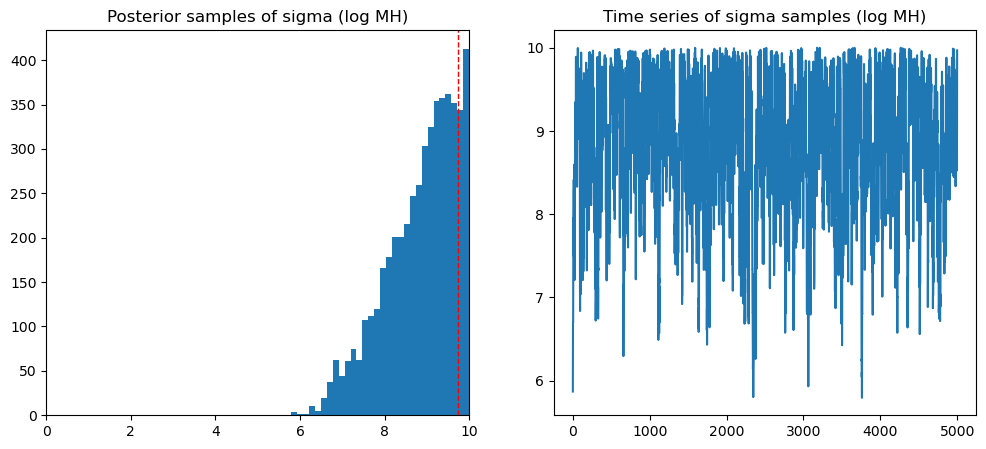

In [ ]:
# Now implement with log probabilities
def log_posterior_sigma(sigma, S, n, A):
    if sigma <= 0 or sigma >= A:
        return -np.inf
    return -n * np.log(sigma) - S / (2 * sigma**2)

def metropolis_hastings(S, n, A, n_samples=5000, tau=0.5, burn_in=1000):
    samples = np.zeros(n_samples)
    
    sigma = np.random.uniform(0, A)
    samples[0] = sigma
    acceptance_count = 0

    for i in range(1, n_samples):
        sigma_proposal = sigma + np.random.normal(0, tau)

        log_p_current = log_posterior_sigma(sigma, S, n, A)
        log_p_proposal = log_posterior_sigma(sigma_proposal, S, n, A)

        log_acceptance_ratio = log_p_proposal - log_p_current
        
        if np.log(np.random.rand()) < log_acceptance_ratio:
            sigma = sigma_proposal
            acceptance_count += 1

        samples[i] = sigma

    print(f"Acceptance rate: {acceptance_count / n_samples:.2f}")

    return samples[burn_in:]

xs = X[index_to_plot]

samples_log = metropolis_hastings(np.sum(xs**2), n, A, tau=0.6, burn_in=0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(samples_log, bins=30)
plt.xlim(0, A)
plt.axvline(sigmas[index_to_plot], color='r', linestyle='dashed', linewidth=1)
plt.title("Posterior samples of sigma (log MH)")
plt.subplot(1, 2, 2)
plt.plot(samples_log)
plt.title("Time series of sigma samples (log MH)")

## Hamiltonian Monte Carlo (HMC)

- [A Conceptual Introduction to HMC](https://arxiv.org/pdf/1701.02434)
- [Information theory, inference and learning algorithms](https://www.inference.org.uk/itprnn/book.pdf)

### Idea

The idea behind HMC is to model the posterior distribution as a Hamiltonian system, where the parameters of interest (in our case, $\sigma$) are treated as positions of particles, and auxiliary momentum variables are introduced to simulate the dynamics of these particles in a potential energy landscape defined by the negative log-posterior.


If we have $d$ parameters, then we introduce a corresponding *dual momentum* variable for each parameter, resulting in a $2d$-dimensional state space. We want this new space to be invariant in volume under reparameterization (eg $dqdp= d\tilde{q}d\tilde{p}$). - Why?????

We then introduce the *canonical distribution* over this state space, which is given by:

$$
\pi(q,p) = \pi(p|q) \pi(q)
$$

We can see that the marginal distribution is still our target distribution $\pi(q)$ - and therefore any trajectories exploring this space will project to trajectories exploring the typical set of our target distribution.

Due to $\pi(q,p)$ being invariant under parameterization, we can write it in terms of an invariant Hamiltonian $H(q,p)$: ??????????
$$
\pi(q,p) =e^{-H(q,p)}
$$
Where $Z$ is a normalizing constant. This gives:
$$
\begin{aligned}
H(q,p) & = -\log \pi(q,p) - \log \pi(q)  \\
& =\quad K(p,q) \quad+ U(q)
\end{aligned}
$$
Analogous to kinetic $K(p,q)$ and potential $U(q)$ energy in a physical system.
- Potential energy $U(q) = -\log \pi(q)$ - this is known (negative log-posterior)
- Kinetic energy $K(p,q) = -\log \pi(p|q)$ - this is flexible, commonly chosen as $K(p,q) = \frac{1}{2} p^T M^{-1} p$ where $M$ is a mass matrix.

Following the Hamiltonian vector field for some time $t$, generrates trajectories $\phi_t(q,p)$.



### Variable transformation
Firstly for our problem, we will try and estimate $\theta = \log \sigma$ as HMC works on $\mathbb{R}^n$. We will still have to deal with the upper bound $A$ on $\sigma$ later through rejection sampling. This means we need to perform a change of variables:
$$
\begin{aligned}
p_\theta(\theta \mid x) &= p_\sigma(\sigma \mid x) \left| \frac{d\sigma}{d\theta} \right| \\
&= p_\sigma(e^\theta \mid x) e^\theta \\
&= \frac{1}{A} \cdot \mathbb{1}_{0 < e^\theta < A} \cdot (e^\theta)^{-n} \exp\left(-\frac{S}{2 (e^\theta)^2} \right) e^\theta \\
\end{aligned}
$$
Which gives us the log-posterior:
$$
\log p_\theta(\theta \mid x) = -\log A - (n-1) \theta - \frac{S}{2 e^{2\theta}} \quad \quad \quad \text{for } 0 < e^\theta < A
$$

### Algorithm
The HMC algorithm then proceeds as follows:
1. Initialise the position $\theta_0$ (e.g., randomly from the prior) 
2. Initialise the momentum $p_0$ from a standard normal distribution $p_0 \sim \mathcal N(0, m)$. Here $m$ is a mass of our fictional particle (often set to 1).
3. Our **Hamiltonian** is given by: 
   $$
   H(\theta, p) = U(\theta) + K(p)
   $$
   - where $U(\theta) = -\log p(\theta \mid x)$ is the potential energy (negative log-posterior) and $K(p) = \frac{1}{2m} p^T p$ is the kinetic energy.

   - This means that, in our case:
   
    $$
    \begin{aligned}
    \dot{\theta} &= \frac{\partial H}{\partial p} = \frac{p}{m} \\
    \dot{p} &= -\frac{\partial H}{\partial \theta} = (n-1) - S e^{-2\theta}
    \end{aligned}
    $$

4. Perform **leapfrog integration** with step size $\epsilon$ and number of steps $L$:
5. Accept or reject the new state $(\theta^*, p^*)$ based on the *Metropolis criterion*:
   $$
   \begin{aligned}
   \alpha &= \min \left\{1, \frac{\pi(\theta^*, p^*)}{\pi(\theta_i, p_i)}\right\} \\

   \implies \log \alpha &=  - H(\theta^*, p^*) + H(\theta_i, p_i) \\
   &= -\log p(\theta^* \mid x) + \log p(\theta_i \mid x) - \frac{1}{2m} (p^{*2} - p_i^2) \\
   &= - (N-1)(\theta^* - \theta_i) - \frac{S}{2} (e^{-2\theta^*} - e^{-2\theta_i}) - \frac{1}{2m} (p^{*2} - p_i^2)
   \end{aligned}
   $$

6. If any intermediate $\sigma = \exp(\theta)$ leaves the support $(0, A)$, reject the proposal and keep the current state.

Acceptance rate: 0.87


Text(0.5, 1.0, 'Time series of sigma samples (HMC)')

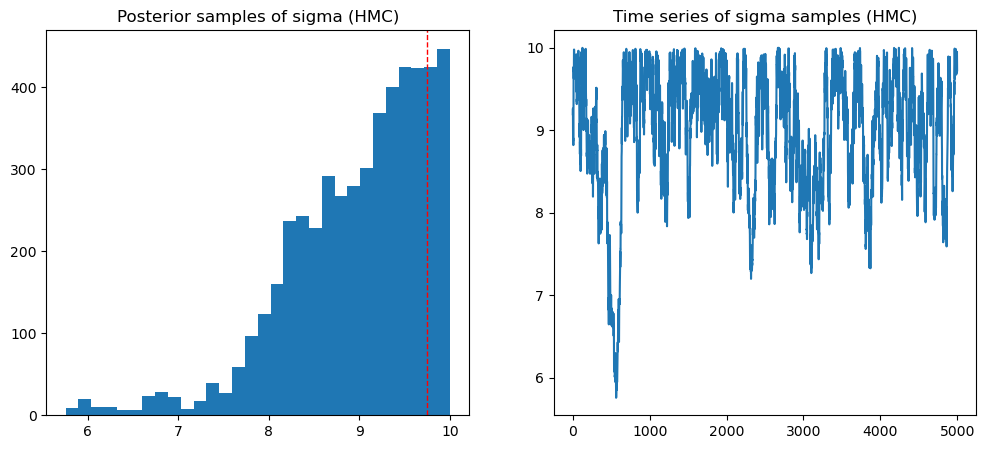

In [132]:
from numerical_integration import leapfrog

def log_posterior(theta, S, n, A):
    sigma = np.exp(theta)
    if sigma <= 0 or sigma >= A:
        #print("Breached upper bound A")
        return -np.inf

    return -(n-1)*theta - S / (2 * sigma**2)

def hamiltonian_monte_carlo(S, n, A, n_samples=5000, L=10, epsilon=0.1, m=1.0, burn_in=1000):
    samples = np.zeros(n_samples)
    
    theta = np.log(np.random.uniform(0, A))
    p = np.random.normal(0, m)

    samples[0] = theta

    acceptance_count = 0

    for i in range(1, n_samples):
        p = np.random.normal(0, m)

        proposals = leapfrog(
            q0 = theta,
            p0 = p,
            dt = epsilon,
            n_steps = L,
            q_dot = lambda p:  p / m,
            p_dot = lambda theta: (n-1) - S * np.exp(-2 * theta)
        )

        theta_proposal, p_proposal = proposals


        log_p_current = log_posterior(theta, S, n, A)
        log_p_proposal = log_posterior(theta_proposal, S, n, A)

        current_H = -log_p_current + (p**2) / (2 * m)
        proposal_H = -log_p_proposal + (p_proposal**2) / (2 * m)

        log_acceptance_ratio = current_H - proposal_H
        
        if np.log(np.random.rand()) < log_acceptance_ratio:
            theta = theta_proposal
            acceptance_count += 1

        samples[i] = theta
        
    print(f"Acceptance rate: {acceptance_count / n_samples:.2f}")
    return np.exp(samples[burn_in:])


xs = X[index_to_plot]

samples_hmc = hamiltonian_monte_carlo(np.sum(xs**2), n, A, L=4, epsilon=0.005, burn_in=0)
# plot both as subplots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(samples_hmc, bins=30)
plt.axvline(sigmas[index_to_plot], color='r', linestyle='dashed', linewidth=1)
plt.title("Posterior samples of sigma (HMC)")
plt.subplot(1, 2, 2)
plt.plot(samples_hmc)
plt.title("Time series of sigma samples (HMC)")

### NUTS (No-U-Turn Sampler)

Let us now try and implement the NUTS (No-U-Turn Sampler) algorithm, which is an extension of HMC that eliminates the need to manually set $L$ (the number of leapfrog steps) by adaptively determining when to stop based on the trajectory's behavior.

They denote $p_\pm(t)$ and $q_\pm(t)$ the momentum and position at each boundary (forwards and backwards in time). Then the NO-U-Turn criterion is given by:
$$
\begin{aligned}
p_+(t)^T\cdot (q_+(t) - q_-(t)) &< 0 \\
p_-(t)^T\cdot (q_-(t) - q_+(t)) &< 0
\end{aligned}
$$
ie, the momentum at either end of the trajectory is pointing back towards the other end, indicating a "U-turn" in the trajectory. If this is not the case, we continue integrating.

C:\Users\kaima\AppData\Local\Temp\ipykernel_7736\2285929787.py:30: RuntimeWarning: overflow encountered in exp
  s = int(u < np.exp(10000 + H0 - H_new))  # prevent numerical issues0


<function matplotlib.pyplot.xlim(*args, **kwargs) -> 'tuple[float, float]'>

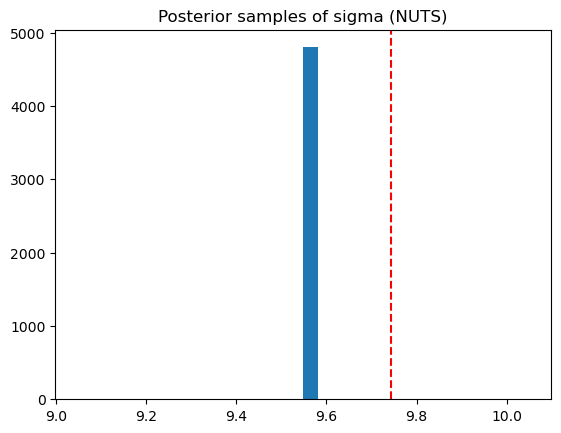

In [157]:

def nuts_criterion(p_plus, p_minus, q_plus, q_minus):
    term1 = np.dot(p_plus, (q_plus - q_minus)) < 0
    term2 = np.dot(p_minus, (q_minus - q_plus)) < 0
    return (term1 and term2)

def grad_log_p(theta, S, n, A):
    sigma = np.exp(theta)
    if sigma <= 0 or sigma >= A:
        return 0.0
    return -(n-1) + S * np.exp(-2 * theta)

def nuts_tree(theta, p, u, v, j, epsilon, H0, S, n, A, m):
    if j == 0:
        # Base case - take single leapfrog step

        theta_new, p_new = leapfrog(
            q0 = theta,
            p0 = p,
            dt = epsilon,
            n_steps = 1,
            q_dot = lambda p:  p / m,
            p_dot = lambda theta: - grad_log_p(theta, S, n, A)
        )

        log_p_new = log_posterior(theta_new, S, n, A)
        H_new = -log_p_new + (p_new**2) / (2 * m)

    
        n_valid = int(u < np.exp(H0 - H_new))
        s = int(u < np.exp(10000 + H0 - H_new))  # prevent numerical issues0

        return theta_new, p_new, theta_new, p_new, theta_new, n_valid, s\
        
    else:
        # Recursion
        theta_minus, p_minus, theta_plus, p_plus, theta_candidate, n_valid, s = nuts_tree(
            theta, p, u, v, j - 1, epsilon, H0, S, n, A, m
        )
        if s == 1:
            # if the stop criterion is still valid, we can keep going

            if v == -1:
                # Move backwards in time
                theta_minus, p_minus, _, _, theta_candidate2, n_valid2, s2 = nuts_tree(
                    theta_minus, p_minus, u, v, j - 1, epsilon, H0, S, n, A, m
                )
            else:
                # Move forwards in time
                _, _, theta_plus, p_plus, theta_candidate2, n_valid2, s2 = nuts_tree(
                    theta_plus, p_plus, u, v, j - 1, epsilon, H0, S, n, A, m
                )

            # Randomly choose which candidate to keep
            if np.random.rand() < n_valid2 / max(n_valid + n_valid2, 1):
                theta_candidate = theta_candidate2

            n_valid += n_valid2
            s = s2 and not nuts_criterion(p_plus, p_minus, theta_plus, theta_minus)

        return theta_minus, p_minus, theta_plus, p_plus, theta_candidate, n_valid, s


def nuts_sampler(S, n, A, num_samples=1000, m=1.0, epsilon=0.1, max_depth=10, burn_in=200):
    samples = []
    theta = np.log(np.random.uniform(0.1, A))  # initialize in log(sigma) space

    for i in range(num_samples):
        p0 = np.random.normal(0, np.sqrt(m))
        logp0 = log_posterior(theta, S, n, A)
        H0 = -logp0 + 0.5 * (p0 ** 2) / m
        u = np.random.uniform(0, np.exp(-H0))

        theta_minus = theta
        theta_plus = theta
        p_minus = p0
        p_plus = p0
        theta_candidate = theta
        n_valid = 1
        s = 1
        j = 0

        while s == 1 and j < max_depth:
            v = np.random.choice([-1, 1])
            if v == -1:
                theta_minus, p_minus, _, _, theta_prime, n_prime, s_prime = nuts_tree(
                    theta_minus, p_minus, u, v, j, epsilon, m, H0, S, n, A
                )
            else:
                _, _, theta_plus, p_plus, theta_prime, n_prime, s_prime = nuts_tree(
                    theta_plus, p_plus, u, v, j, epsilon, m, H0, S, n, A
                )

            if s_prime == 1 and np.random.rand() < n_prime / max(n_valid + n_prime, 1):
                theta_candidate = theta_prime

            n_valid += n_prime
            s = s_prime and not nuts_criterion(p_plus, p_minus, theta_plus, theta_minus)
            j += 1

        theta = theta_candidate
        samples.append(theta)

    return np.exp(np.array(samples[burn_in:]))  # return samples of sigma, not theta


xs = X[index_to_plot]
samples_nuts = nuts_sampler(np.sum(xs**2), n=n, A=A, num_samples=5000, epsilon=0.0008)

plt.hist(samples_nuts, bins=30)
plt.axvline(sigmas[index_to_plot], color='r', linestyle='dashed')
plt.title("Posterior samples of sigma (NUTS)")
plt.xlim


C:\Users\kaima\AppData\Local\Temp\ipykernel_7736\3001975473.py:37: RuntimeWarning: overflow encountered in exp
  stop = False if u < np.exp(-H_new + 1000) else True  # numerical stability


<function matplotlib.pyplot.xlim(*args, **kwargs) -> 'tuple[float, float]'>

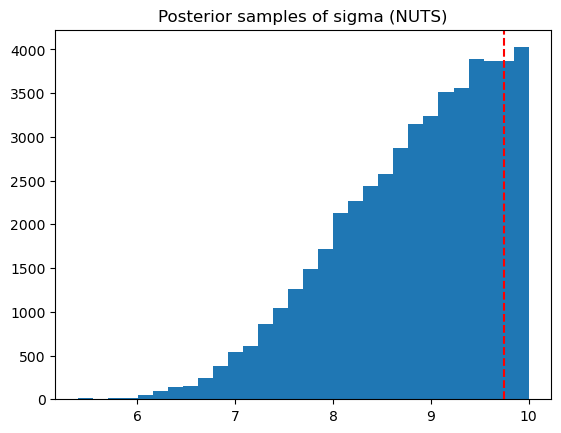

In [163]:
def simple_nuts(S, n, A, n_samples=1000, epsilon=0.01, max_tree_depth=10):
      """
      Simplified NUTS sampler - easier to understand
      """

      def log_posterior(theta):
          sigma = np.exp(theta)
          if sigma <= 0 or sigma >= A:
              return -np.inf
          return -(n-1)*theta - S/(2*sigma**2)

      def grad_log_posterior(theta):
          sigma = np.exp(theta)
          if sigma <= 0 or sigma >= A:
              return 0.0
          return -(n-1) + S*np.exp(-2*theta)

      def leapfrog_step(theta, p, epsilon):
          """Single leapfrog step"""
          p = p + 0.5 * epsilon * grad_log_posterior(theta)
          theta = theta + epsilon * p
          p = p + 0.5 * epsilon * grad_log_posterior(theta)
          return theta, p

      def build_tree(theta, p, u, direction, depth, epsilon):
          """
          Build a tree by doubling
          Returns: (theta_minus, p_minus, theta_plus, p_plus, theta_sample, n_valid, stop)
          """
          if depth == 0:
              # Base case: single leapfrog step
              theta_new, p_new = leapfrog_step(theta, p, direction * epsilon)

              # Check if we should accept this sample
              H_new = -log_posterior(theta_new) + 0.5 * p_new**2
              n_valid = 1 if u <= np.exp(-H_new) else 0
              stop = False if u < np.exp(-H_new + 1000) else True  # numerical stability

              return theta_new, p_new, theta_new, p_new, theta_new, n_valid, stop

          # Recursive case: build left and right subtrees
          theta_m, p_m, theta_p, p_p, theta_sample, n_valid, stop = \
              build_tree(theta, p, u, direction, depth-1, epsilon)

          if stop:
              return theta_m, p_m, theta_p, p_p, theta_sample, n_valid, stop

          # Build second subtree
          if direction > 0:
              # Going forward
              theta_m2, p_m2, theta_p2, p_p2, theta_sample2, n_valid2, stop2 = \
                  build_tree(theta_p, p_p, u, direction, depth-1, epsilon)
              theta_p = theta_p2
              p_p = p_p2
          else:
              # Going backward
              theta_m2, p_m2, theta_p2, p_p2, theta_sample2, n_valid2, stop2 = \
                  build_tree(theta_m, p_m, u, direction, depth-1, epsilon)
              theta_m = theta_m2
              p_m = p_m2

          # Choose which sample to return
          if n_valid2 > 0 and np.random.rand() < n_valid2/(n_valid + n_valid2):
              theta_sample = theta_sample2

          # Check U-turn condition
          span = theta_p - theta_m
          stop = stop2 or (p_p * span < 0) or (p_m * span < 0)

          return theta_m, p_m, theta_p, p_p, theta_sample, n_valid + n_valid2, stop

      # Main sampling loop
      samples = []
      theta = np.log(np.random.uniform(0.1, A-0.1))  # Start in valid region

      for _ in range(n_samples):
          # Sample momentum
          p0 = np.random.randn()

          # Compute initial Hamiltonian
          H0 = -log_posterior(theta) + 0.5 * p0**2

          # Slice variable for accept/reject
          u = np.random.uniform(0, np.exp(-H0))

          # Initialize
          theta_m = theta
          theta_p = theta
          p_m = p0
          p_p = p0
          n_valid = 1
          stop = False
          depth = 0
          theta_sample = theta

          # Build tree until U-turn
          while not stop and depth < max_tree_depth:
              # Choose direction randomly
              direction = np.random.choice([-1, 1])

              if direction == 1:
                  # Extend forward
                  _, _, theta_p2, p_p2, theta_propose, n_propose, stop_propose = \
                      build_tree(theta_p, p_p, u, direction, depth, epsilon)
                  theta_p = theta_p2
                  p_p = p_p2
              else:
                  # Extend backward
                  theta_m2, p_m2, _, _, theta_propose, n_propose, stop_propose = \
                      build_tree(theta_m, p_m, u, direction, depth, epsilon)
                  theta_m = theta_m2
                  p_m = p_m2

              # Check if we should use this proposal
              if not stop_propose and n_propose > 0:
                  if np.random.rand() < n_propose / (n_valid + n_propose):
                      theta_sample = theta_propose

              # Update
              n_valid += n_propose

              # Check U-turn
              span = theta_p - theta_m
              stop = stop_propose or (p_p * span < 0) or (p_m * span < 0)

              depth += 1

          theta = theta_sample
          samples.append(np.exp(theta))  # Convert back to sigma

      return np.array(samples)

xs = X[index_to_plot]
samples_nuts = simple_nuts(np.sum(xs**2), n=n, A=A, n_samples=5000, epsilon=0.01)

plt.hist(samples_nuts, bins=30)
plt.axvline(sigmas[index_to_plot], color='r', linestyle='dashed')
plt.title("Posterior samples of sigma (NUTS)")
plt.xlim


## Neural Network Inference (posterior mean)

In [134]:
import torch
import torch.nn as nn
import torch.nn.functional as nnf

class MLP(nn.Module):
    ''' Simple MLP with ReLU activations (variable number of hidden layers) '''

    def __init__(self, input_dim, output_dim, hidden_dim, n_layers=2):
        super(MLP, self).__init__()

        layers = []
        
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.nn = nn.Sequential(*layers)

    def forward(self, x):
        return self.nn(x)

Now we will attempt to train a simple neural network to learn the posterior distribution. Firstly we just aim to infer the posterior mean $\hat{\sigma}$. ie we aim to train the neural network $f_\phi(\vec x)$ such that:
$$
f_\phi(\vec x) \approx \mathbb{E}[\sigma \mid x]
$$
where $\phi$ are the parameters of the neural network.

We will train the network on the pairs $(\sigma, \vec x)$ drawn from the joint distribution. To get the neural network to target the posterior mean, we will use the following loss function:

$$
L(\sigma, \vec x) = (f_\phi(\vec x) - \sigma)^2
$$

### Loss function choice
We seek to minimise the expected squared error:
$$
\begin{aligned}
\mathbb{E} [(\sigma - f_\phi(\vec x))^2 \, \mid \, \vec x] &= \mathbb{E} \big[\sigma^2 - 2 \sigma f_\phi(\vec x) + f_\phi(\vec x)^2\, \mid \, \vec x \big] \\
&= \mathbb{E}[\sigma^2 \, \mid \, \vec x] - 2 f_\phi(\vec x) \mathbb{E}[\sigma \, \mid \, \vec x] + f_\phi(\vec x)^2 \\


\end{aligned}
$$

To minimise with respect to $f_\phi(\vec x)$, we take the derivative and set it to zero:
$$
\begin{aligned}
\frac{\partial}{\partial f_\phi(\vec x)} \mathbb{E} [(\sigma - f_\phi(\vec x))^2 \, \mid \, \vec x] &= -2 \mathbb{E}[\sigma \, \mid \, \vec x] + 2 f_\phi(\vec x) = 0 \\
\implies f_\phi(\vec x) &= \mathbb{E}[\sigma \, \mid \, \vec x]

\end{aligned}
$$



### Other loss functions
- $L = |\sigma - f_\phi(\vec x)|$ - targets the posterior median
- more generally, to target the $\alpha$-quantile, use:
    $$
    L = \begin{cases}
    \alpha (\sigma - f_\phi(\vec x)) & \text{if } \sigma > f_\phi(\vec x) \\
    (1 - \alpha) (f_\phi(\vec x) - \sigma) & \text{otherwise}
    \end{cases}
    $$
- $L = -\log p(\sigma \mid f_\phi(\vec x))$ - targets the posterior mode (MAP estimate)
- $L(y, p) = y \log p + (1-y) \log(1-p)$ - targets the probability $P(y=1 \mid x)$ for binary classification problems
- etc

### Neural Network Architecture

We are given i.i.d. observations $\vec x = (x_1, \ldots, x_n)$ which means we need our neural network to be permutation invariant. We can achieve this by using a __Deep Sets architecture__:
1. Use first neural network to generate a *summary vector* of each observation:
$$
h_i = MLP_1(x_i)
$$
2. Aggregate these summary vectors using a permutation invariant operation (sum, mean, max, etc) to get a single summary vector
$$
H = \sum_{i=1}^{n} h_i
$$
3. Use a second neural network to map this summary vector to the final output (in our case we use __softplus__ to ensure positivity):
$$
\hat{\sigma} = softplus(MLP_2(H))
$$

This architecture is a neural anaolgue of a __sufficient statistic__. ie we are trying to learn what summary statistic is sufficient for estimating $\sigma$.

In [135]:
class PosteriorMeanEstimator(nn.Module):
    def __init__(self,
        summary_stats=32,
        summary_width=32,
        estimator_width=32):
        
        super().__init__()

        # MLP point layer
        self.mlp_point = MLP(
            input_dim=1, 
            output_dim=summary_stats, 
            hidden_dim=summary_width,
            n_layers=2)

        # MLP aggregate layer
        self.mlp_aggregate = MLP(
            input_dim=summary_stats, 
            output_dim=1, 
            hidden_dim=estimator_width,
            n_layers=2)

    def forward(self, x):
        
        # Step 1. encode observations independently
        x = x.unsqueeze(-1)  # (batch_size, n, 1)

        summaries = self.mlp_point(x)  # (batch_size, n, summary_stats)

        # Step 2. aggregate summaries
        H = summaries.sum(dim=1)  # (batch_size, summary_stats)
        
        # Step 3. final estimate nn
        out = self.mlp_aggregate(H)  # (batch_size, 1)

        return nnf.softplus(out.squeeze(-1))  


# test untrained network with our index_to_plot

input_obs = torch.tensor(X[index_to_plot], dtype=torch.float32).unsqueeze(0)  # (1, n)

neural_estimator = PosteriorMeanEstimator()

sigma_hat = neural_estimator(input_obs)

print(f"sigma: {sigmas[index_to_plot]:.2f}")
print(f"sigma_hat: {sigma_hat.item():.2f}")

sigma: 9.74
sigma_hat: 0.26


### Training

In [136]:
def sample_batch(batch_size):
  sigma_batch = torch.rand(batch_size) * A
  x_batch = torch.normal(0, sigma_batch.reshape(-1, 1).expand(-1, n))
  sigma_batch_tensor = sigma_batch
  x_batch_tensor = x_batch
  return sigma_batch_tensor, x_batch_tensor

sigma_batch_test, x_test = sample_batch(1024)

loss_fn = torch.nn.MSELoss()

test_output = neural_estimator(x_test)
test_loss = loss_fn(test_output, sigma_batch_test)
print(test_loss)

tensor(27.9072, grad_fn=<MseLossBackward0>)


In [137]:
n_epochs = 128
n_batches_per_epoch = 128
training_batch_size = 128

# Set up optimizer
optimizer = torch.optim.Adam(neural_estimator.parameters(), lr=0.00001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = 0.0

    sigma_epoch_batches, x_epoch_batches = sample_batch(n_batches_per_epoch * training_batch_size)
    
    for batch_idx in range(n_batches_per_epoch):
        # Sample a batch
        batch_idx_start = batch_idx * training_batch_size
        batch_idx_end = batch_idx_start + training_batch_size
        sigma_batch = sigma_epoch_batches[batch_idx_start:batch_idx_end]
        x_batch = x_epoch_batches[batch_idx_start : batch_idx_end]
        
        optimizer.zero_grad()
        sigma_pred = neural_estimator(x_batch)
        loss = loss_fn(sigma_pred, sigma_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / n_batches_per_epoch
    with torch.no_grad():
        sigma_pred_test = neural_estimator(x_test)
        test_loss = loss_fn(sigma_pred_test, sigma_batch_test).item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_epoch_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/128, Train Loss: 28.1878, Test Loss: 27.1351
Epoch 2/128, Train Loss: 26.9490, Test Loss: 25.9230
Epoch 3/128, Train Loss: 25.4034, Test Loss: 24.1697
Epoch 4/128, Train Loss: 23.3134, Test Loss: 21.6744
Epoch 5/128, Train Loss: 20.2612, Test Loss: 18.0587
Epoch 6/128, Train Loss: 15.7571, Test Loss: 12.9572
Epoch 7/128, Train Loss: 10.4204, Test Loss: 7.9384
Epoch 8/128, Train Loss: 6.0091, Test Loss: 4.5732
Epoch 9/128, Train Loss: 3.5117, Test Loss: 2.9401
Epoch 10/128, Train Loss: 2.3982, Test Loss: 2.3976
Epoch 11/128, Train Loss: 2.0758, Test Loss: 2.2284
Epoch 12/128, Train Loss: 1.9411, Test Loss: 2.1445
Epoch 13/128, Train Loss: 1.8948, Test Loss: 2.0810
Epoch 14/128, Train Loss: 1.8624, Test Loss: 2.0279
Epoch 15/128, Train Loss: 1.7692, Test Loss: 1.9781
Epoch 16/128, Train Loss: 1.7999, Test Loss: 1.9358
Epoch 17/128, Train Loss: 1.7856, Test Loss: 1.9001
Epoch 18/128, Train Loss: 1.7721, Test Loss: 1.8672
Epoch 19/128, Train Loss: 1.7015, Test Loss: 1.8419
Epoch 20

Text(0, 0.5, 'Estimated sigma')

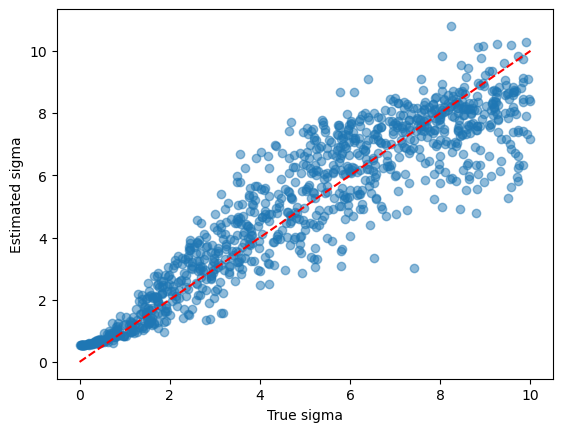

In [138]:
sigma_hat_test = neural_estimator(x_test)

plt.scatter(sigma_batch_test.numpy(), sigma_hat_test.detach().numpy(), alpha=0.5)
plt.plot([0, A], [0, A], color='r', linestyle='dashed')
plt.xlabel("True sigma")
plt.ylabel("Estimated sigma")

In [139]:
# compare with MCMC (metropolis-hastings)
sigmas_mcmc = np.zeros(x_test.shape[0])
for i in range(x_test.shape[0]):
    xs = x_test[i].numpy()
    samples = metropolis_hastings(np.sum(xs**2), n, A, tau=0.1, burn_in=1000)
    sigma = np.mean(samples)

    sigmas_mcmc[i] = sigma

Acceptance rate: 0.84
Acceptance rate: 0.95
Acceptance rate: 0.97
Acceptance rate: 0.90
Acceptance rate: 0.88
Acceptance rate: 0.80
Acceptance rate: 0.95
Acceptance rate: 0.95
Acceptance rate: 0.96
Acceptance rate: 0.97
Acceptance rate: 0.97
Acceptance rate: 0.92
Acceptance rate: 0.97
Acceptance rate: 0.97
Acceptance rate: 0.97
Acceptance rate: 0.97
Acceptance rate: 0.90
Acceptance rate: 0.95
Acceptance rate: 0.38
Acceptance rate: 0.96
Acceptance rate: 0.98
Acceptance rate: 0.92
Acceptance rate: 0.93
Acceptance rate: 0.97
Acceptance rate: 0.85
Acceptance rate: 0.84
Acceptance rate: 0.90
Acceptance rate: 0.91
Acceptance rate: 0.98
Acceptance rate: 0.76
Acceptance rate: 0.97
Acceptance rate: 0.97
Acceptance rate: 0.97
Acceptance rate: 0.92
Acceptance rate: 0.98
Acceptance rate: 0.97
Acceptance rate: 0.80
Acceptance rate: 0.79
Acceptance rate: 0.94
Acceptance rate: 0.96
Acceptance rate: 0.97
Acceptance rate: 0.94
Acceptance rate: 0.98
Acceptance rate: 0.93
Acceptance rate: 0.96
Acceptance

MCMC loss: 1.3477463722229004
Neural Estimator loss: 1.2335288524627686
neural_estimator loss to MCMC: 0.2931407392024994


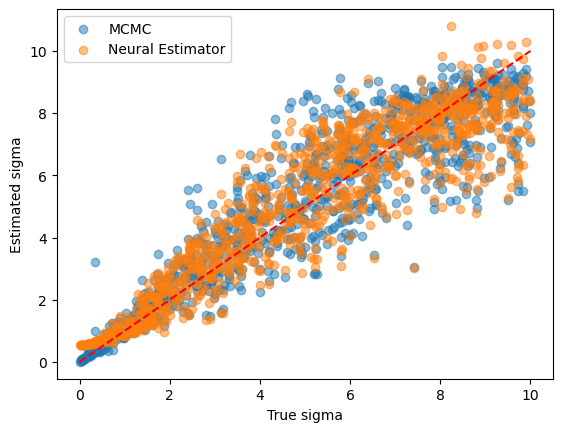

In [140]:
plt.scatter(sigma_batch_test.numpy(), sigmas_mcmc, alpha=0.5, label='MCMC')
plt.scatter(sigma_batch_test.numpy(), sigma_hat_test.detach().numpy(), alpha=0.5, label='Neural Estimator')
plt.plot([0, A], [0, A], color='r', linestyle='dashed')
plt.xlabel("True sigma")
plt.ylabel("Estimated sigma")
plt.legend()

print("MCMC loss:", loss_fn(torch.tensor(sigmas_mcmc, dtype=torch.float32), sigma_batch_test).item())
print("Neural Estimator loss:", loss_fn(sigma_hat_test, sigma_batch_test).item())

print("neural_estimator loss to MCMC:", loss_fn(sigma_hat_test, torch.tensor(sigmas_mcmc, dtype=torch.float32)).item())

Text(0, 0.5, 'Neural Estimated sigma')

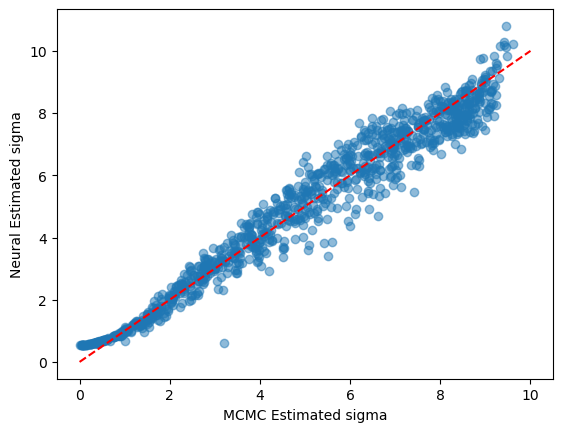

In [141]:
# plot NN vs MCMC
plt.scatter(sigmas_mcmc, sigma_hat_test.detach().numpy(), alpha=0.5)
plt.plot([0, A], [0, A], color='r', linestyle='dashed')
plt.xlabel("MCMC Estimated sigma")
plt.ylabel("Neural Estimated sigma")

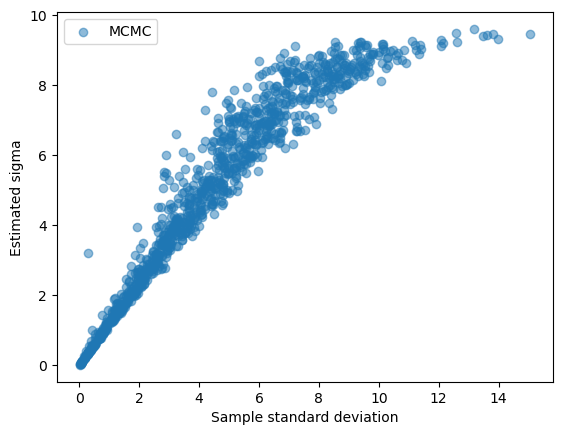

In [142]:
# plot MCMC against sample standard deviations
plt.scatter(np.std(x_test.numpy(), axis=1), sigmas_mcmc, alpha=0.5, label='MCMC')
plt.xlabel("Sample standard deviation")
plt.ylabel("Estimated sigma")
plt.legend()


## Neural Network Inference (posterior quantile)

We need a loss function of the form:
$$
L = \begin{cases}
\alpha (\sigma - f_\phi(\vec x)) & \text{if } \sigma > f_\phi(\vec x) \\
(1 - \alpha) (f_\phi(\vec x) - \sigma) & \text{otherwise}
\end{cases}
$$

Prove that this targets the $\alpha$-quantile of the posterior distribution.

In [149]:
# quantile
alpha = 0.1

# def quantile_loss(sigma, sigma_hat, alpha=0.5):
#     Ls = torch.where(sigma > sigma_hat, alpha * (sigma - sigma_hat), (1 - alpha) * (sigma_hat - sigma))
#     return torch.mean(Ls)

def quantile_loss(y_pred, y_true, alpha=alpha):
    error = y_true - y_pred
    return torch.mean(torch.maximum(alpha * error, (alpha - 1) * error))



In [150]:
n_epochs = 128
n_batches_per_epoch = 128
training_batch_size = 128

# Set up optimizer
optimizer = torch.optim.Adam(neural_estimator.parameters(), lr=0.00001)

# Training loop
for epoch in range(n_epochs):
    epoch_loss = 0.0

    sigma_epoch_batches, x_epoch_batches = sample_batch(n_batches_per_epoch * training_batch_size)
    
    for batch_idx in range(n_batches_per_epoch):
        # Sample a batch
        batch_idx_start = batch_idx * training_batch_size
        batch_idx_end = batch_idx_start + training_batch_size
        sigma_batch = sigma_epoch_batches[batch_idx_start:batch_idx_end]
        x_batch = x_epoch_batches[batch_idx_start : batch_idx_end]
        
        optimizer.zero_grad()
        sigma_pred = neural_estimator(x_batch)
        loss = loss_fn(sigma_pred, sigma_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / n_batches_per_epoch
    with torch.no_grad():
        sigma_pred_test = neural_estimator(x_test)
        test_loss = loss_fn(sigma_pred_test, sigma_batch_test).item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_epoch_loss:.4f}, Test Loss: {test_loss:.4f}")


Epoch 1/128, Train Loss: 1.0973, Test Loss: 1.2008
Epoch 2/128, Train Loss: 1.0999, Test Loss: 1.2031
Epoch 3/128, Train Loss: 1.1114, Test Loss: 1.2041
Epoch 4/128, Train Loss: 1.1113, Test Loss: 1.1960
Epoch 5/128, Train Loss: 1.0908, Test Loss: 1.1962
Epoch 6/128, Train Loss: 1.1015, Test Loss: 1.2011
Epoch 7/128, Train Loss: 1.0926, Test Loss: 1.1995
Epoch 8/128, Train Loss: 1.1010, Test Loss: 1.1980
Epoch 9/128, Train Loss: 1.0976, Test Loss: 1.1971
Epoch 10/128, Train Loss: 1.0934, Test Loss: 1.2003
Epoch 11/128, Train Loss: 1.1216, Test Loss: 1.2024
Epoch 12/128, Train Loss: 1.1007, Test Loss: 1.1959
Epoch 13/128, Train Loss: 1.0809, Test Loss: 1.2027
Epoch 14/128, Train Loss: 1.0855, Test Loss: 1.1950
Epoch 15/128, Train Loss: 1.0937, Test Loss: 1.1924
Epoch 16/128, Train Loss: 1.1056, Test Loss: 1.2018
Epoch 17/128, Train Loss: 1.1009, Test Loss: 1.1994
Epoch 18/128, Train Loss: 1.1165, Test Loss: 1.1977
Epoch 19/128, Train Loss: 1.0952, Test Loss: 1.1982
Epoch 20/128, Train L

In [151]:
sigmas_mcmc = np.zeros(x_test.shape[0])
for i in range(x_test.shape[0]):
    xs = x_test[i].numpy()
    samples = metropolis_hastings(np.sum(xs**2), n, A, tau=0.1, burn_in=1000)
    sigma = np.median(samples)
    sigmas_mcmc[i] = sigma


sigma_hat_test = neural_estimator(x_test)

Acceptance rate: 0.82
Acceptance rate: 0.95
Acceptance rate: 0.97
Acceptance rate: 0.90
Acceptance rate: 0.87
Acceptance rate: 0.78
Acceptance rate: 0.95
Acceptance rate: 0.95
Acceptance rate: 0.96
Acceptance rate: 0.97
Acceptance rate: 0.98
Acceptance rate: 0.91
Acceptance rate: 0.97
Acceptance rate: 0.96
Acceptance rate: 0.97
Acceptance rate: 0.97
Acceptance rate: 0.90
Acceptance rate: 0.94
Acceptance rate: 0.39
Acceptance rate: 0.96
Acceptance rate: 0.98
Acceptance rate: 0.93
Acceptance rate: 0.93
Acceptance rate: 0.97
Acceptance rate: 0.83
Acceptance rate: 0.82
Acceptance rate: 0.91
Acceptance rate: 0.92
Acceptance rate: 0.98
Acceptance rate: 0.74
Acceptance rate: 0.97
Acceptance rate: 0.97
Acceptance rate: 0.96
Acceptance rate: 0.92
Acceptance rate: 0.97
Acceptance rate: 0.95
Acceptance rate: 0.65
Acceptance rate: 0.74
Acceptance rate: 0.93
Acceptance rate: 0.96
Acceptance rate: 0.97
Acceptance rate: 0.92
Acceptance rate: 0.98
Acceptance rate: 0.93
Acceptance rate: 0.95
Acceptance

MCMC loss: 1.4144529104232788
Neural Estimator loss: 1.1818927526474
neural_estimator loss to MCMC: 0.2537481486797333


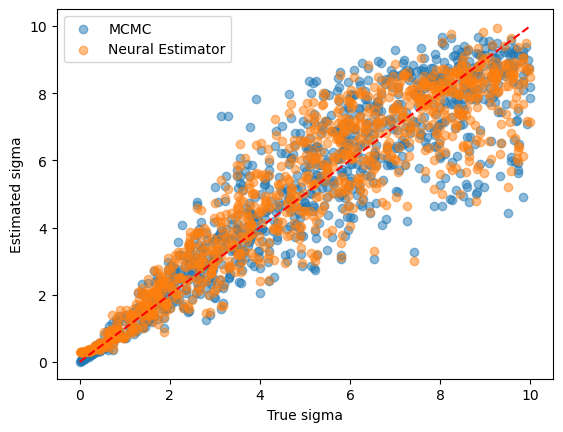

In [152]:
plt.scatter(sigma_batch_test.numpy(), sigmas_mcmc, alpha=0.5, label='MCMC')
plt.scatter(sigma_batch_test.numpy(), sigma_hat_test.detach().numpy(), alpha=0.5, label='Neural Estimator')
plt.plot([0, A], [0, A], color='r', linestyle='dashed')
plt.xlabel("True sigma")
plt.ylabel("Estimated sigma")
plt.legend()

print("MCMC loss:", loss_fn(torch.tensor(sigmas_mcmc, dtype=torch.float32), sigma_batch_test).item())
print("Neural Estimator loss:", loss_fn(sigma_hat_test, sigma_batch_test).item())

print("neural_estimator loss to MCMC:", loss_fn(sigma_hat_test, torch.tensor(sigmas_mcmc, dtype=torch.float32)).item())

## Questions

- could we use the probit transformation to deal with both lower and upper bounds on $\sigma$?
- I don't understand some of the reasoning behind invariant parameterization leading to Hamiltonian
- Why doubling in the NUTS algorithm? couldn't you skip a uturn?
- why does the neural estimator fail for small sigma


trials
1. larger n, significantly less variance from true in both, still obvious error at small and large sigma.
2. couldn't find a way to get it to more exactly find MCMC (even deeper and wider), maybe different loss function?
